Scanpy data loading tutorial from
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
# Check dependencies

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 pynndescent==0.5.5


1. Load the data into an AnnData Object

In [4]:
# Set read/write directories
input_folder = 'data/filtered_gene_bc_matrices/hg19/'
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [5]:
# Create AnnData object
adata = sc.read_10x_mtx(
    input_folder,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

2. Inspect the data and conduct initial preprocessing

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [7]:
# Inspect the AnnData variables

adata.var['gene_ids'].head

<bound method NDFrame.head of MIR1302-10      ENSG00000243485
FAM138A         ENSG00000237613
OR4F5           ENSG00000186092
RP11-34P13.7    ENSG00000238009
RP11-34P13.8    ENSG00000239945
                     ...       
AC145205.1      ENSG00000215635
BAGE5           ENSG00000268590
CU459201.1      ENSG00000251180
AC002321.2      ENSG00000215616
AC002321.1      ENSG00000215611
Name: gene_ids, Length: 32738, dtype: object>

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [9]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


normalizing counts per cell
    finished (0:00:00)


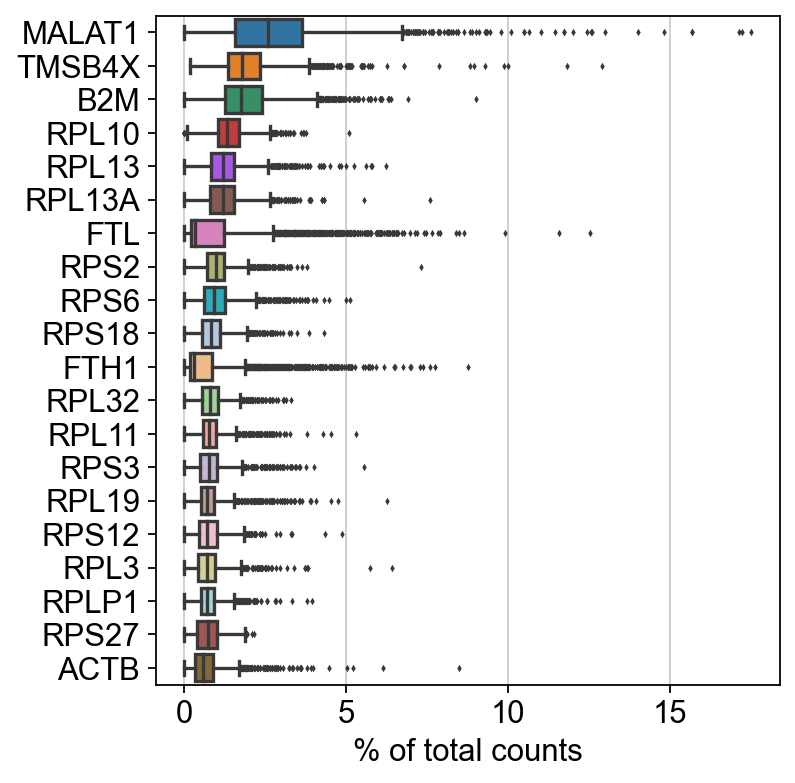

In [10]:
# Identify highest expressing genes
sc.pl.highest_expr_genes(adata, n_top=20, )

In [11]:
# Inspect the proportion of mitochondrial genes

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Generates a boolean mask for genes starting with 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)  # Returns total_counts_['mt'] for vars fed in via qc_vars
adata.var['mt']

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: mt, Length: 13714, dtype: bool

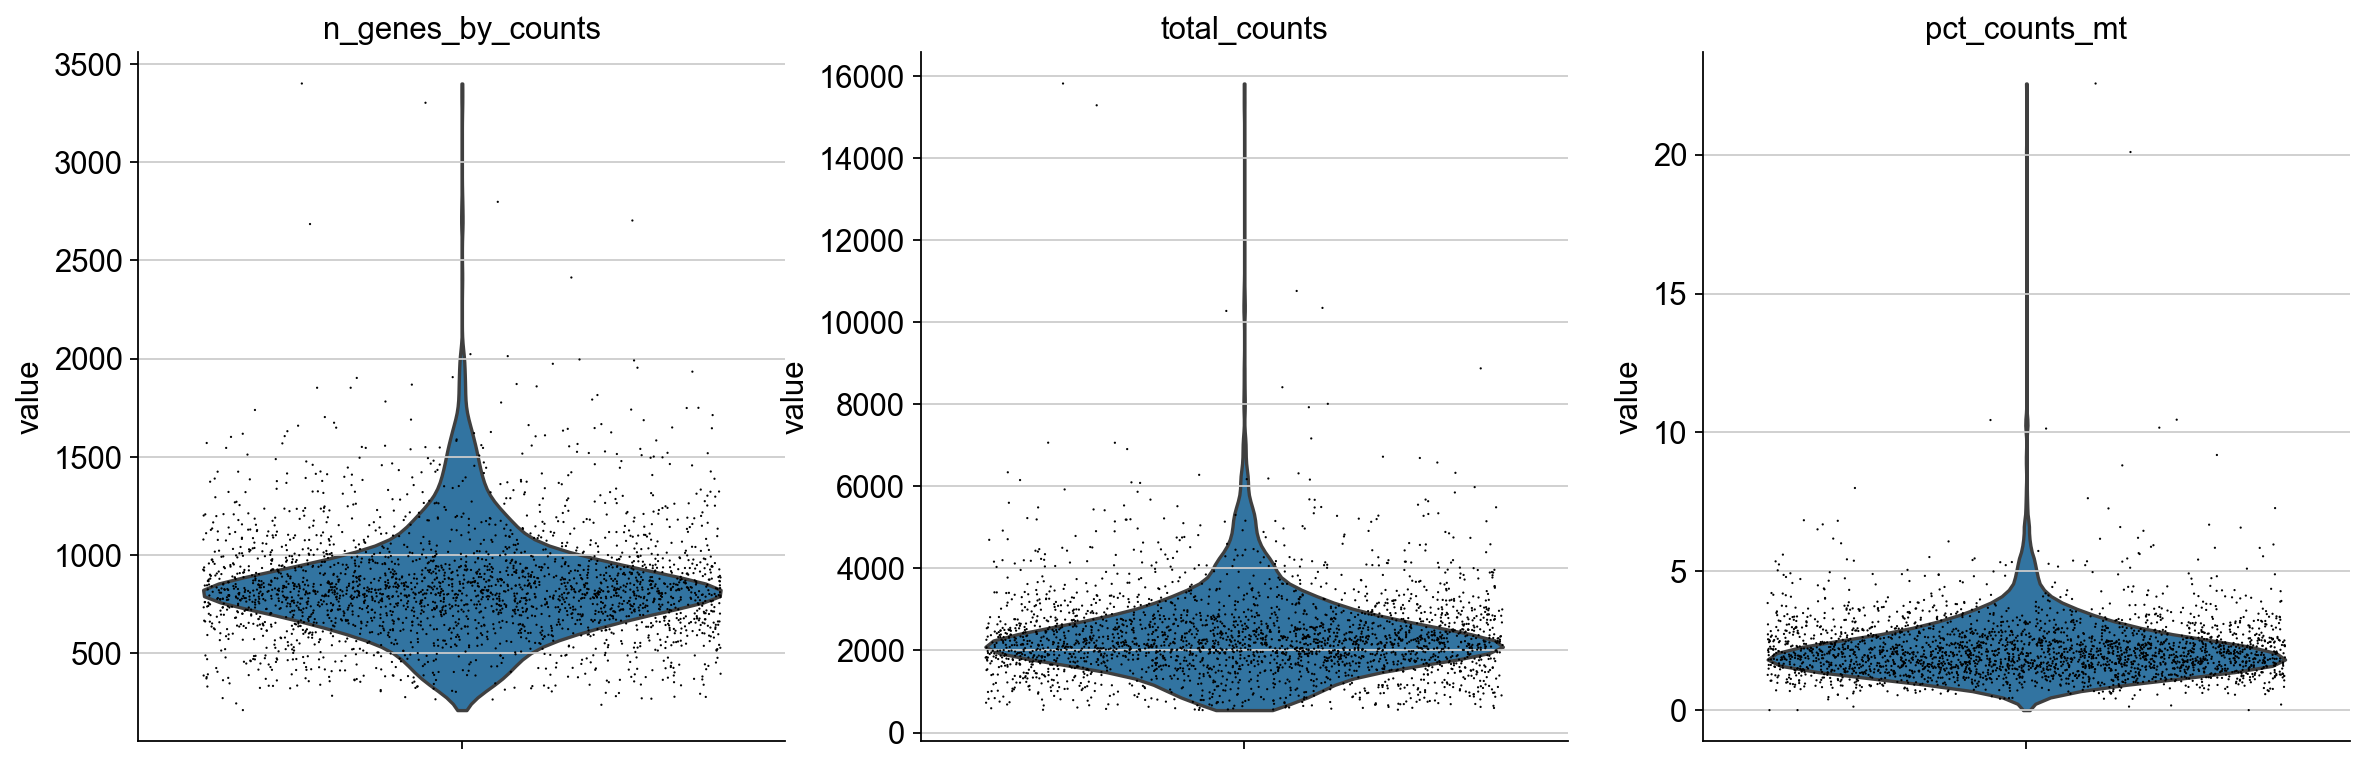

In [12]:
# Generate violin plots for variables of interest

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts','pct_counts_mt'],
             jitter=0.4, multi_panel=True)

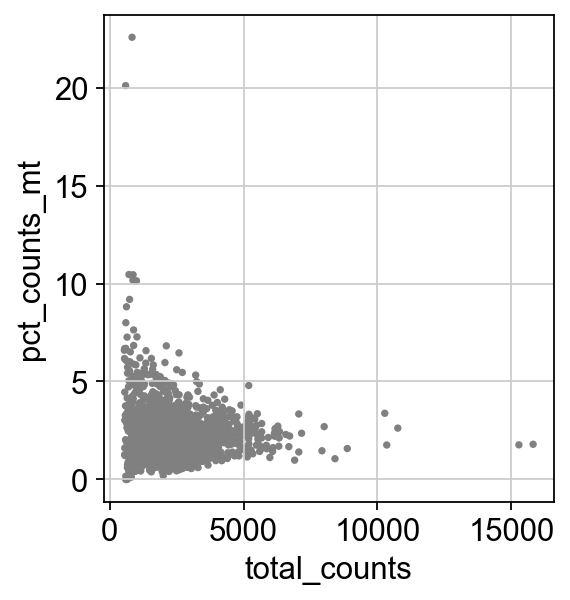

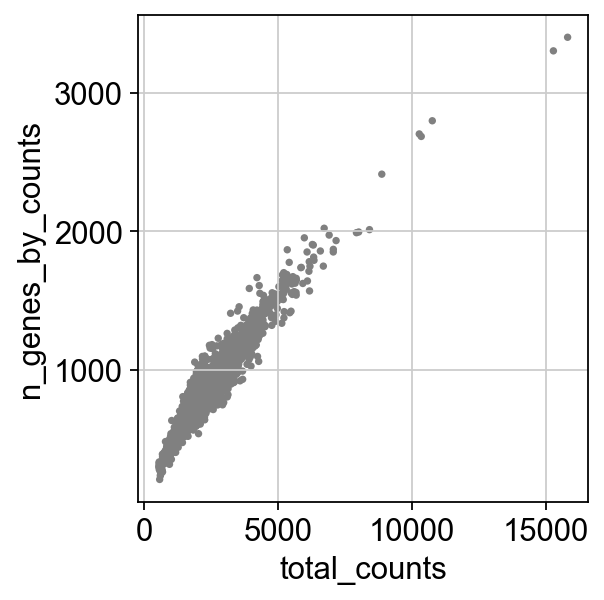

In [13]:
# Inspect distribution of mitochondrial genes

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

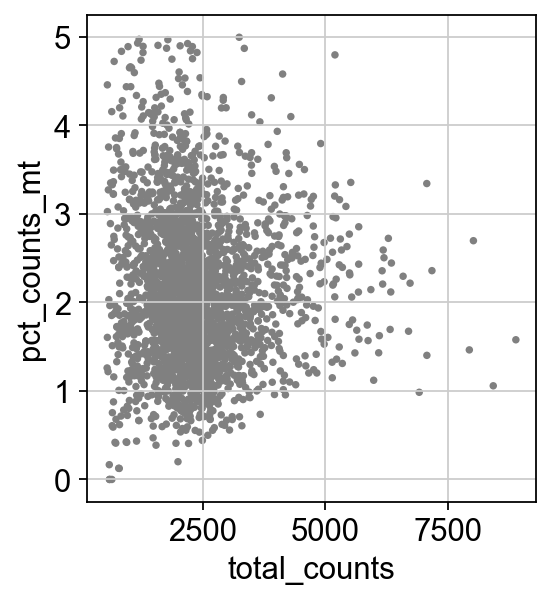

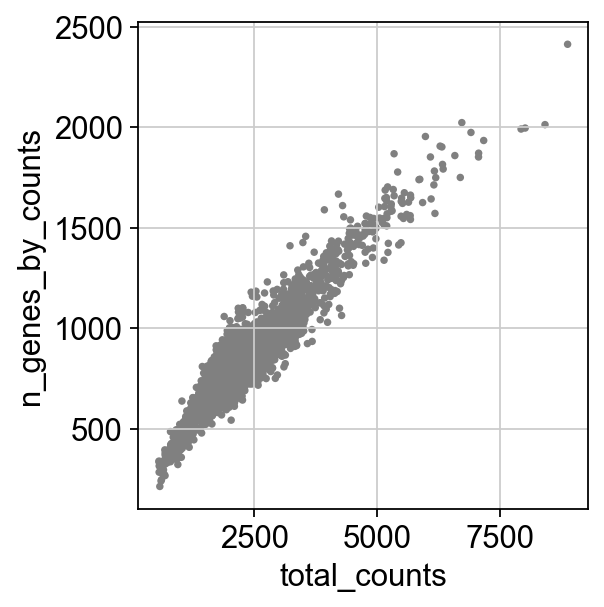

In [14]:
# Filter dead cells

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
# Normalise and log1p the data - data stored as adata.X

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print("L")


normalizing counts per cell
    finished (0:00:00)
L


/Users/danhudson/opt/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
# log1p data will now be stored under 'uns'
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

highly_variable
AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

means
AL627309.1       0.013556
AP006222.2       0.004696
RP11-206L10.2    0.005673
RP11-206L10.9    0.002644
LINC00115        0.027437
                   ...   
AC145212.1       0.027441
AL592183.1       0.485051
AL354822.1       0.012157
PNRC2-1          0.160366
SRSF10-1         0.100255
Name: means, Length: 13714, dtype: float64

dispersions
AL627309.1       1.432845
AP006222.2       1.458631
RP11-206L10.2    1.325459
RP11-2

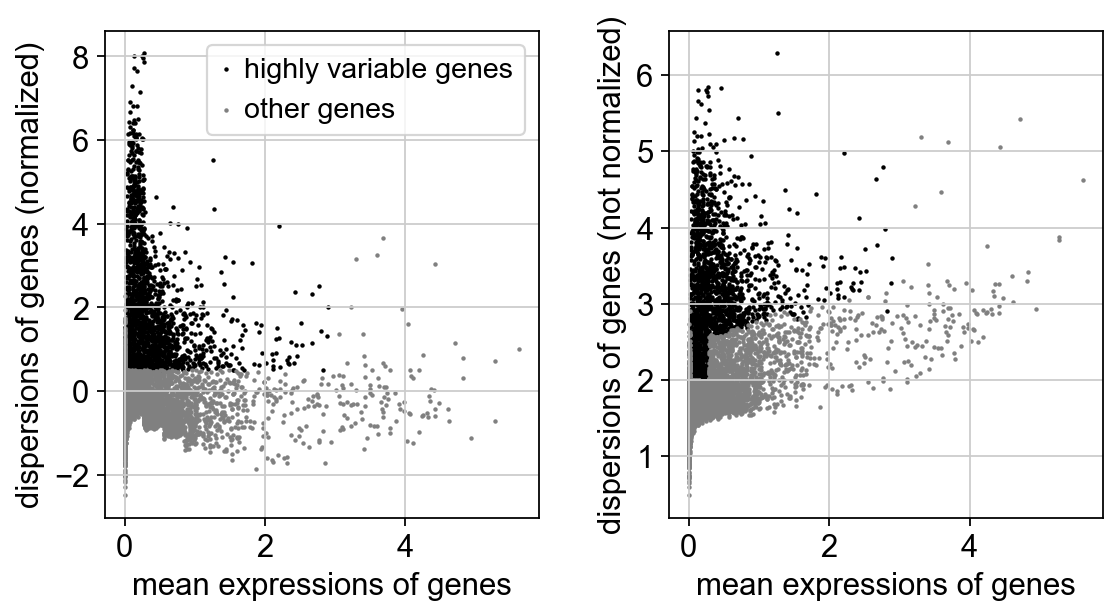

In [17]:
# Inspect highly variable genes - stored under adata.var

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
for var in ['highly_variable','means','dispersions','dispersions_norm']:
    print("\n%s\n%s"%(var,adata.var[var]))
sc.pl.highly_variable_genes(adata)

In [18]:
# Freeze the state of the AnnData object

adata.raw = adata
adata.raw.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0,False,0.013556,1.432845,-0.624328
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0,False,0.004696,1.458631,-0.573416
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0,False,0.005673,1.325459,-0.836358
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0,False,0.002644,0.859264,-1.756848
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0,False,0.027437,1.457477,-0.575693
...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,16,False,16,0.006667,99.407407,18.0,False,0.027441,1.784637,0.070275
AL592183.1,ENSG00000220023,323,False,323,0.134815,88.037037,364.0,False,0.485051,1.859941,-0.437388
AL354822.1,ENSG00000215615,8,False,8,0.002963,99.703704,8.0,False,0.012157,1.781924,0.064919
PNRC2-1,ENSG00000215700,110,False,110,0.042963,95.925926,116.0,False,0.160366,1.567491,-0.358474


In [19]:
# Filter for the most variable genes
adata = adata[:, adata.var.highly_variable]
adata.var


,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
TNFRSF4,ENSG00000186827,155,False,155,0.077407,94.259259,209.0,True,0.277410,2.086050,0.665406
CPSF3L,ENSG00000127054,202,False,202,0.094815,92.518519,256.0,True,0.385194,4.506987,2.955005
ATAD3C,ENSG00000215915,9,False,9,0.009259,99.666667,25.0,True,0.038252,3.953486,4.352607
C1orf86,ENSG00000162585,501,False,501,0.227778,81.444444,615.0,True,0.678283,2.713522,0.543183
RER1,ENSG00000157916,608,False,608,0.298148,77.481481,805.0,True,0.814813,3.447533,1.582528
...,...,...,...,...,...,...,...,...,...,...,...
ICOSLG,ENSG00000160223,34,False,34,0.016667,98.740741,45.0,True,0.082016,2.585818,1.652185
SUMO3,ENSG00000184900,570,False,570,0.292963,78.888889,791.0,True,0.804815,4.046776,2.431045
SLC19A1,ENSG00000173638,31,False,31,0.018519,98.851852,50.0,True,0.058960,3.234231,2.932458
S100B,ENSG00000160307,94,False,94,0.076667,96.518519,207.0,True,0.286282,3.042992,1.078783


In [20]:
# Regress out the impact of total cell counts and mt expression
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) 

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


In [21]:
# Scale to unit variance, clipping at 10 STD
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


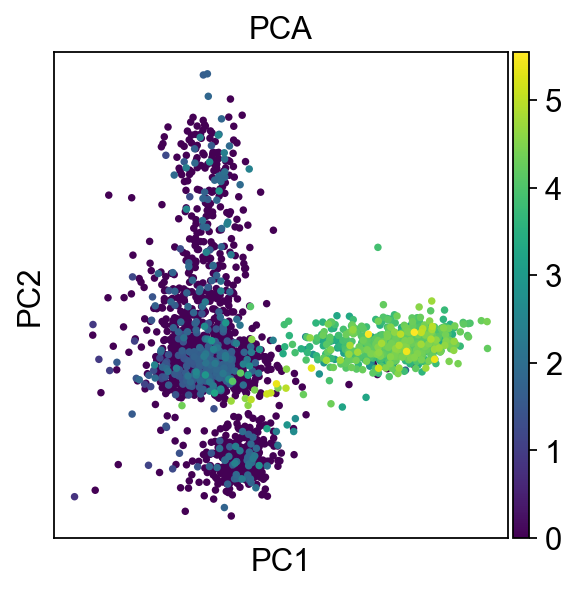

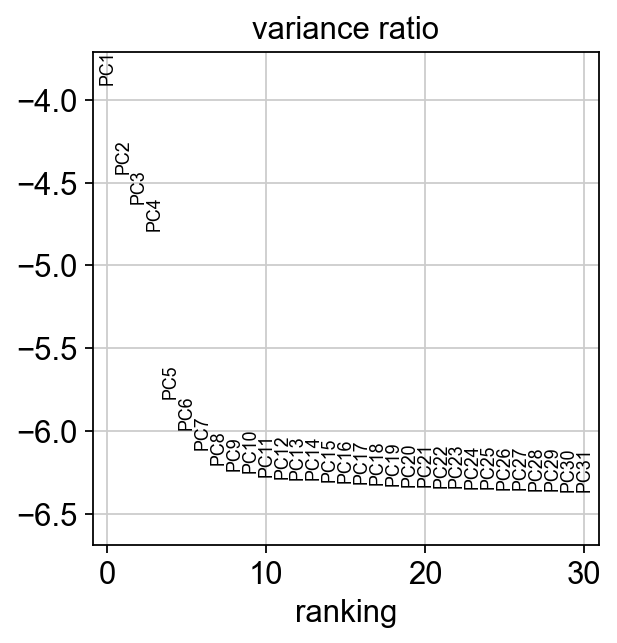

In [22]:
# Run PCA to reduce dimensionality
sc.tl.pca(adata, svd_solver='arpack') # NB you don't need to filter out cells on hvg if running PCA
sc.pl.pca(adata, color='CST3',title="PCA")
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
# Save results
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'